In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Icehockey')

In [3]:
data = dm.__get_data__()

In [4]:
data.head()

odds        prob        \
                                                     0     1     0     1   
MatchDate  HomeTeam    AwayTeam   bkmr                                     
2010-05-07 USA         Germany    unibet_op_ha_   3.65  1.25  0.26  0.74   
2010-05-08 Finland     Denmark    unibet_op_ha_  11.00  1.02  0.08  0.92   
           Switzerland Latvia     unibet_op_ha_   2.80  1.40  0.33  0.67   
2010-05-09 Belarus     Kazakhstan unibet_op_ha_   3.55  1.26  0.26  0.74   
           Norway      Sweden     unibet_op_ha_  10.50  1.02  0.09  0.91   

                                                  book FTR  
                                                            
MatchDate  HomeTeam    AwayTeam   bkmr                      
2010-05-07 USA         Germany    unibet_op_ha_  0.074   0  
2010-05-08 Finland     Denmark    unibet_op_ha_  0.071   0  
           Switzerland Latvia     unibet_op_ha_  0.071   1  
2010-05-09 Belarus     Kazakhstan unibet_op_ha_  0.075   1  
           Norway      Sweden     unibet_op_ha_  0.076   1

In [5]:
train = data[data.index.get_level_values(0) < datetime(2017, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2017, 1, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'FTR'])
matrix = matrix[matrix.sum(axis=1) > 1000]

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

FTR                      0       1
(prob, 0) (prob, 1)               
0.23      0.77       228.0   778.0
0.24      0.76       263.0   821.0
0.26      0.74       345.0   985.0
0.27      0.73       392.0  1120.0
0.28      0.72       369.0   889.0

In [9]:
vicini = test.prob.apply(get_neighbours, axis=1).rename('NN').to_frame()
probs  = vicini.apply(dm.ubibetter.__compute_probs_avg__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [10]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=4).merge(test['FTR'], right_index=True, left_index=True)

In [11]:
aux.head(6)

level_4   odd      prob  FTR
MatchDate  HomeTeam     AwayTeam bkmr                                         
2017-01-02 Ambri-Piotta Davos    bet365_op_ha_          0  1.95  0.456431    0
                                 bet365_op_ha_          1  1.85  0.543569    0
                                 bwin_op_ha_            0  1.95  0.450954    0
                                 bwin_op_ha_            1  1.75  0.549046    0
                                 marathon_op_ha_        0  2.07  0.450954    0
                                 marathon_op_ha_        1  1.86  0.549046    0

In [12]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction)

In [13]:
frac = frac.stack().rename('frac').to_frame()

In [14]:
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [15]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [16]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

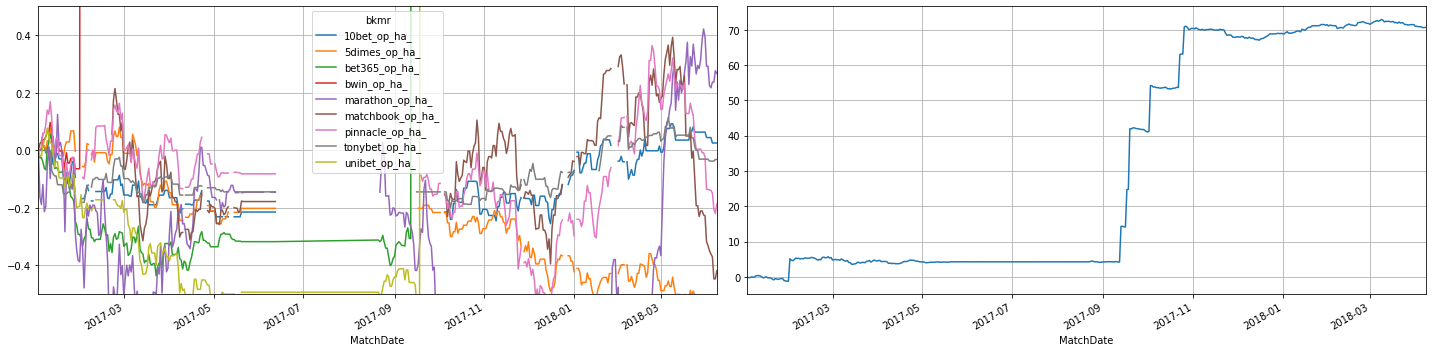

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0], grid=True, ylim=(-0.5, 0.5))
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1], grid=True)
plt.tight_layout()

In [18]:
aux.head()

level_4   odd      prob  \
MatchDate  HomeTeam     AwayTeam bkmr                                       
2017-01-02 Ambri-Piotta Davos    bet365_op_ha_          0  1.95  0.456431   
                                 bet365_op_ha_          1  1.85  0.543569   
                                 bwin_op_ha_            0  1.95  0.450954   
                                 bwin_op_ha_            1  1.75  0.549046   
                                 marathon_op_ha_        0  2.07  0.450954   

                                                  FTR    frac  margin  
MatchDate  HomeTeam     AwayTeam bkmr                                  
2017-01-02 Ambri-Piotta Davos    bet365_op_ha_      0  0.0000  0.0000  
                                 bet365_op_ha_      0  0.0066 -0.0066  
                                 bwin_op_ha_        0  0.0000  0.0000  
                                 bwin_op_ha_        0  0.0000 -0.0000  
                                 marathon_op_ha_    0  0.0000  0.0000

In [19]:
tst = aux[aux.index.get_level_values(3) == 'pinnacle_op_ha_']

In [20]:
team = pd.concat([tst.margin.groupby(level=1).mean(), tst.margin.groupby(level=2).mean()], axis=0)

In [54]:
selection = team.groupby(level=0).mean().sort_values(ascending=False).iloc[:10]

In [55]:
selection

Toronto Maple Leafs    0.000813
Tampa Bay Lightning    0.000789
Detroit Red Wings      0.000682
Montreal Canadiens     0.000677
Anaheim Ducks          0.000648
Florida Panthers       0.000638
New Jersey Devils      0.000562
Dallas Stars           0.000477
Edmonton Oilers        0.000426
St. Louis Blues        0.000355
Name: margin, dtype: float64

In [56]:
tst = aux[((aux.index.get_level_values(1).isin(selection.index)) | 
           (aux.index.get_level_values(2).isin(selection.index)))&
           (aux.index.get_level_values(3) == 'pinnacle_op_ha_')]

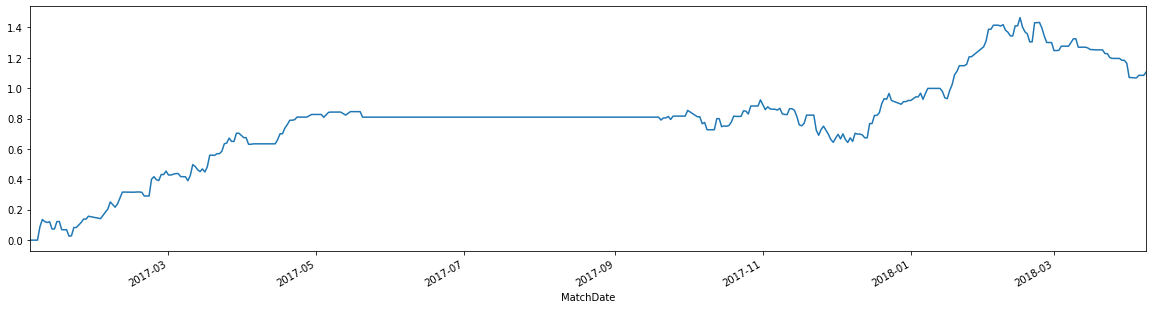

In [57]:
tst.margin.groupby(level=0).sum().cumsum().plot(figsize=(20, 5))

In [34]:
selection

Toronto Maple Leafs    0.000813
Tampa Bay Lightning    0.000789
Detroit Red Wings      0.000682
Montreal Canadiens     0.000677
Anaheim Ducks          0.000648
Florida Panthers       0.000638
New Jersey Devils      0.000562
Dallas Stars           0.000477
Edmonton Oilers        0.000426
St. Louis Blues        0.000355
Name: margin, dtype: float64

In [36]:
team_counts = pd.concat([tst.groupby(level=1).count().margin.rename('home'), 
                         tst.groupby(level=2).count().margin.rename('away')], axis=1, sort=False)

team_counts = team_counts.loc[selection.index].dropna(axis=0)

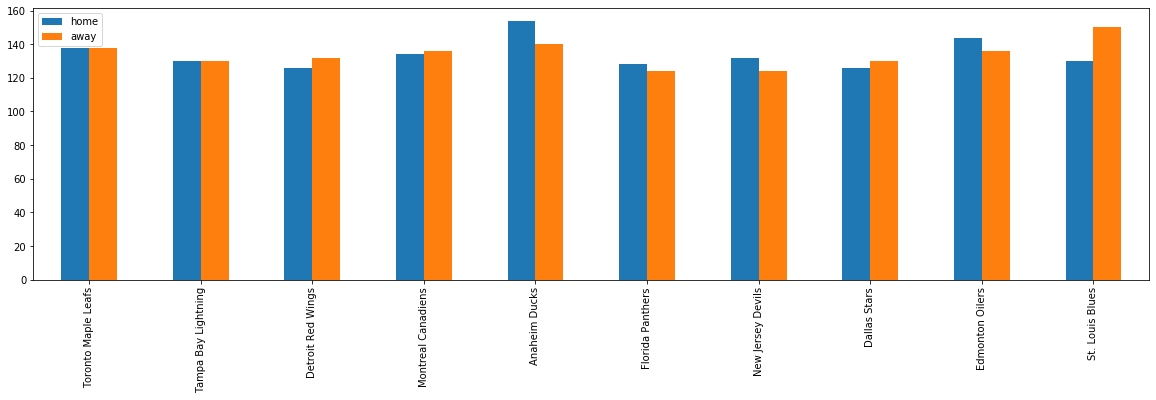

In [37]:
team_counts.plot.bar(figsize=(20, 5))